In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

# Task 1 - 2D Ising model

## Datasets

In [2]:
from numba import njit, prange, jit

In [58]:
@njit
def metropolis_ising(L, J=1.0, h=0.0, beta=0.4, n_steps=100000, spins = None):
    # Initialize spin configuration randomly
    if spins is None:
        spins = np.random.choice(np.array([-1, 1]), size=(L, L))
            
    for step in range(n_steps):
        i, j = np.random.randint(0, L, size=2)

        neighbor_sum = (
            spins[i, (j + 1) % L] +
            spins[i, (j - 1) % L] +
            spins[(i + 1) % L, j] +
            spins[(i - 1) % L, j])
        
        delta_E = 2 * spins[i, j] * (J * neighbor_sum + h)

        # Compute local energy difference
        # delta_E = 2 * spins[i, j] * (J * sum(spins[x, y] for x, y in neighbors(i, j)) + h)

        # Metropolis criterion
        if delta_E <= 0 or np.random.rand() < np.exp(-beta * delta_E):
            spins[i, j] *= -1
            
    return spins

@njit(parallel=True)
def ising_dataset(nt, N, mcSteps, num_configs, T, seed):
    configurations = np.zeros((nt, num_configs, N, N), dtype=np.int8)  # Store configurations

    M = np.zeros((nt, mcSteps))

    for tt in range(nt):
        
        iT=1.0/T[tt]; iT2=iT*iT    

        for n in prange(num_configs):
            np.random.seed(seed+tt+n)        
            configurations[tt, n] = metropolis_ising(N, beta = iT, n_steps=mcSteps)
    
    return configurations
        
 

### Testing

In [91]:
nt      = 25         #  number of temperature points
N       = 12         #  size of the lattice, N x N
mcSteps = int(6e5) # 1024       #  number of MC sweeps for calculation
num_configs = 10

Tc = 2/(np.log(1+np.sqrt(2)))

T = np.linspace(Tc-1.5, Tc+1.5, nt); 
labels = (T.repeat(mcSteps) >= Tc).astype(int)



np.random.seed(123)
configs= ising_dataset(nt, N, mcSteps, num_configs, T)

TypeError: not enough arguments: expected 6, got 5

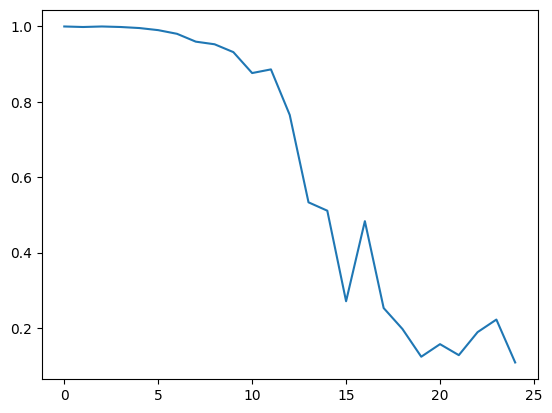

In [7]:
plt.plot(np.abs(configs.sum(-1).sum(-1)).mean(-1)/N**2)

### Reference

In [92]:
nt      = 50         #  number of temperature points
N       = 12         #  size of the lattice, N x N
mcSteps = int(6e5)   # 1024       #  number of MC sweeps for calculation
num_configs = 200

Tc = 2/(np.log(1+np.sqrt(2)))

T = np.linspace(Tc-1.5, Tc+1.5, nt); 
labels = (T.repeat(num_configs) <= Tc).astype(int)

seed_reference = 111

configurations = ising_dataset(nt, N, mcSteps, num_configs, T, seed = seed_reference)
configurations = configurations.reshape(-1, N, N)

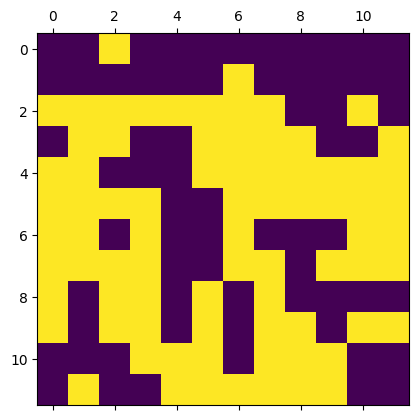

In [125]:
plt.matshow(configurations[-3])

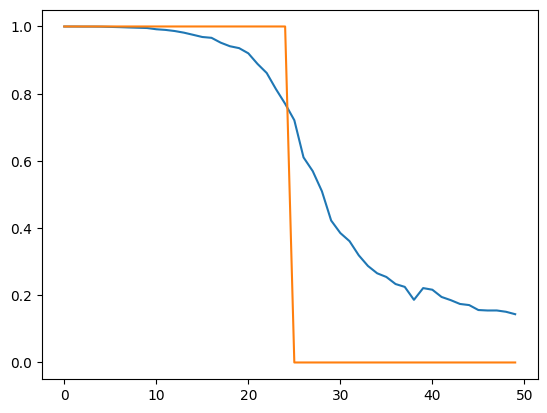

In [94]:
plt.plot(np.abs(configurations.reshape(nt, num_configs, N, N).sum(-1).sum(-1)).mean(-1)/N**2)
plt.plot(labels[::num_configs])

In [72]:
configs_torch = torch.from_numpy(configurations)
labels_torch = torch.from_numpy(labels)


torch.manual_seed(24)
idx_shuffle = torch.randperm(labels_torch.size(0))

configs_torch = configs_torch[idx_shuffle]
labels_torch = labels_torch[idx_shuffle]


torch.save(configs_torch, '../input_data/classification/input_data.pt')
torch.save(labels_torch, '../reference_data/classification/trues.pt')

### Public data

In [74]:
nt      = 50         #  number of temperature points
N       = 12         #  size of the lattice, N x N
mcSteps = int(6e5)   #  number of MC sweeps for calculation
num_configs = 200

Tc = 2/(np.log(1+np.sqrt(2)))

T = np.linspace(Tc-1.5, Tc+1.5, nt); 
labels = (T.repeat(num_configs) <= Tc).astype(int)

seed_public = 222

configurations = ising_dataset(nt, N, mcSteps, num_configs, T, seed = seed_public)
configurations = configurations.reshape(-1, N, N)

In [75]:
configs_torch = torch.from_numpy(configurations)
labels_torch = torch.from_numpy(labels)


torch.manual_seed(42)
idx_shuffle = torch.randperm(labels_torch.size(0))

configs_torch = configs_torch[idx_shuffle]
labels_torch = labels_torch[idx_shuffle]


torch.save(configs_torch, '../public_data/classification/input_data.pt')
torch.save(labels_torch, '../public_data/classification/trues.pt')

## Scoring program

In [96]:
# Load ground truth
print('Loading ground truth labels')
trues = torch.load('../reference_data/classification/trues.pt')
# Results file
print('Loading predicted labels')
preds = torch.load('../public_data/classification/trues.pt')


# preds = 1 - trues.clone()

# preds = torch.rand(trues.shape)



print('Calculating binary cross entropy loss')


loss = torch.nn.BCELoss()
loss(preds.to(float), trues.to(float)).item()

Loading ground truth labels
Loading predicted labels
Calculating binary cross entropy loss


49.48

## Baseline

In [87]:
import torch
from os.path import isfile

class model:
    def __init__(self):
        pass
    
    def pred(self, x):
        mag = x.flatten(1,2).sum(-1) 
        return  (mag.abs() > x.shape[-1]**2/2).to(float)

In [100]:
configs = torch.load('../input_data/classification/input_data.pt')
trues = torch.load('../reference_data/classification/trues.pt')

mod = model()
preds = mod.pred(configs)

loss = torch.nn.BCELoss()
loss(preds.to(float), trues.to(float)).item()

9.71

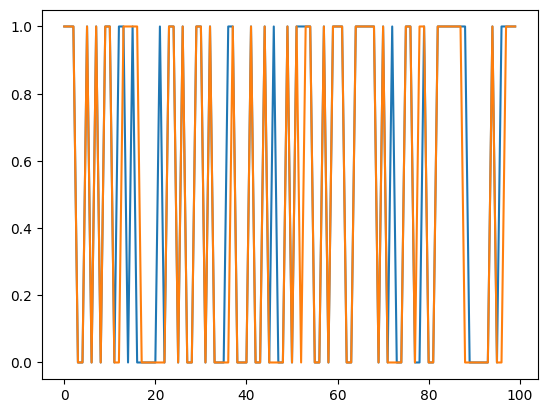

In [101]:
plt.plot(preds[:100])
plt.plot(trues[:100])

# HW 2 -  Anomalous diffusion trajectories

## Datasets

### Reference

In [102]:
from andi_datasets.models_phenom import models_phenom
import torch
import stochastic

md = models_phenom()

In [109]:
T = 200
N = 10000

In [110]:
np.random.seed(1)
stochastic.random.seed(1)
trajs, labels = md.single_state(N = int(N), T = 200, alphas = [1,10])
trajs = trajs[...,0].transpose()
labels = labels[0,:,0]

(array([ 983.,  986., 1069.,  938., 1014., 1082., 1008.,  992.,  985.,
         943.]),
 array([2.00396926e-04, 2.00054685e-01, 3.99908973e-01, 5.99763262e-01,
        7.99617550e-01, 9.99471838e-01, 1.19932613e+00, 1.39918041e+00,
        1.59903470e+00, 1.79888899e+00, 1.99874328e+00]),
 <BarContainer object of 10 artists>)

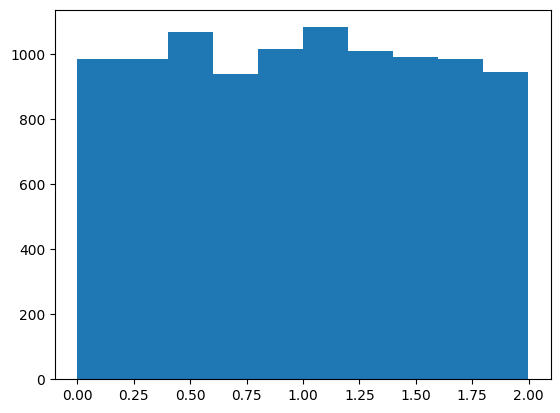

In [111]:
plt.hist(labels)

In [112]:
trajs_torch = torch.from_numpy(trajs)
torch.save(trajs_torch, '../input_data/regression/input_data.pt')

labels_torch = torch.from_numpy(labels)
torch.save(labels_torch, '../reference_data/regression/trues.pt')

### Public data

In [113]:
T = 200
N = 10000

In [114]:
np.random.seed(72)
stochastic.random.seed(79)
trajs, labels = md.single_state(N = int(N), T = T, alphas = [1,10])

trajs = trajs[...,0].transpose()
labels = labels[0,:,0]

In [115]:
trajs_torch = torch.from_numpy(trajs)
torch.save(trajs_torch, '../public_data/regression/input_data.pt')

labels_torch = torch.from_numpy(labels)
torch.save(labels_torch, '../public_data/regression/trues.pt')

## Baseline

In [116]:
from andi_datasets.analysis import msd_analysis


trajs = torch.load('../input_data/regression/input_data.pt')
trues = torch.load('../reference_data/regression/trues.pt').numpy()

# preds = msd_analysis().get_exponent(trajs[:,:,torch.newaxis])

In [117]:
# This is based on msd_analysis but to avoid pip install andi in codabench I just copy paste simplified code

class model:
    def __init__(self):
        pass

    def _tamsd(self, trajs, t_lags):
        tamsd = np.zeros((len(t_lags), trajs.shape[0]), dtype= float)
        
        for idx, tlag in enumerate(t_lags):                  
            tamsd[idx, :] = ((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1).mean(1)

        return tamsd

    
    def pred(self, trajs):

        trajs = trajs.unsqueeze(-1)

        N_t_lags = max(4, int(trajs.shape[1]*0.1))
        t_lags = np.arange(1, N_t_lags)

        tamsd = self._tamsd(trajs, t_lags)

        return np.polyfit(np.log(t_lags), np.log(tamsd), deg = 1)[0]

In [118]:
mod = model()
preds = mod.pred(trajs)


((preds - trues)**2).mean()

np.float64(0.017491810253528133)

## Scoring program

In [ ]:
import sys
import os
import torch

def regression_scoring(INPUT_DIR = None, # directory to where to find the reference and predicted labes
                       OUTPUT_DIR = None # directory where the scores will be saved (scores.txt)
                        ):
    
    if INPUT_DIR is None:
        INPUT_DIR = sys.argv[1]
    if OUTPUT_DIR is None:
        OUTPUT_DIR = sys.argv[2]
        
    submit_dir = os.path.join(INPUT_DIR, 'res')
    truth_dir = os.path.join(INPUT_DIR, 'ref')
    
    if not os.path.isdir(submit_dir):
        print( "%s doesn't exist", submit_dir)
        
    if os.path.isdir(submit_dir) and os.path.isdir(truth_dir):
        if not os.path.exists(OUTPUT_DIR):
            os.makedirs(OUTPUT_DIR)

    output_filename = os.path.join(OUTPUT_DIR, 'scores.txt')
    output_file = open(output_filename, 'w')

    # Load ground truth
    trues = torch.load(os.path.join(truth_dir, 'trues.npy'))
    # Results file
    preds = torch.load(os.path.join(submit_dir, 'preds.npy'))

    assert trues.shape == preds.shape, "Shape of predicted values are incorrect."

    loss = torch.mean((trues - preds) ** 2)

    output_file.write(f'loss: {loss}\n')

# HW 3 - Reinforcement learning